In [13]:
# Introducing library 导入项目所依赖的第三方代码库
# library(tidyverse) # 是一个包含各种与数据科学项目相关的第三方库的综合库
library(dplyr) # 用于数据变换、数据清理
library(caret) # 用于机器学习建模
library(ggplot2) # 用于绘图
library(stringr) # 用于字符串数据处理
library("class")
library(corrplot)
library(randomForest)
library(MASS)

Your code contains a unicode char which cannot be displayed in your
current locale and R will silently convert it to an escaped form when the
R kernel executes this code. This can lead to subtle errors if you use
such chars to do comparisons. For more information, please see
https://github.com/IRkernel/repr/wiki/Problems-with-unicode-on-windows

In [2]:
raw_data <- readr::read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-01-21/spotify_songs.csv')

Parsed with column specification:
cols(
  .default = col_double(),
  track_id = col_character(),
  track_name = col_character(),
  track_artist = col_character(),
  track_album_id = col_character(),
  track_album_name = col_character(),
  track_album_release_date = col_character(),
  playlist_name = col_character(),
  playlist_id = col_character(),
  playlist_genre = col_character(),
  playlist_subgenre = col_character()
)
See spec(...) for full column specifications.


In [3]:
summary(raw_data)
# for (col in names(raw_data)) {
#     print(paste(col,":", typeof(col)))
# }
# print(table(raw_data$playlist_genre))
# print(table(raw_data$playlist_subgenre))

   track_id          track_name        track_artist       track_popularity
 Length:32833       Length:32833       Length:32833       Min.   :  0.00  
 Class :character   Class :character   Class :character   1st Qu.: 24.00  
 Mode  :character   Mode  :character   Mode  :character   Median : 45.00  
                                                          Mean   : 42.48  
                                                          3rd Qu.: 62.00  
                                                          Max.   :100.00  
 track_album_id     track_album_name   track_album_release_date
 Length:32833       Length:32833       Length:32833            
 Class :character   Class :character   Class :character        
 Mode  :character   Mode  :character   Mode  :character        
                                                               
                                                               
                                                               
 playlist_name      playlis

### EDA

In [7]:
idx <- sample(nrow(raw_data), size=2000)
data_eda <- raw_data[idx,]
data_eda$playlist_genre <- as.factor(data_eda$playlist_genre)
data_eda$playlist_subgenre <- as.factor(data_eda$playlist_subgenre)
# data_eda$genre_id <- NULL
# data_eda[, data_eda$genre_id=='pop']$genre_id <- 1
# data_eda[, data_eda$genre_id=='rap']$genre_id <- 2
# data_eda[, data_eda$genre_id=='rock']$genre_id <- 3
# data_eda[, data_eda$genre_id=='latin']$genre_id <- 4
# data_eda[, data_eda$genre_id=='r&b']$genre_id <- 5
# data_eda[, data_eda$genre_id=='edm']$genre_id <- 6

Your code contains a unicode char which cannot be displayed in your
current locale and R will silently convert it to an escaped form when the
R kernel executes this code. This can lead to subtle errors if you use
such chars to do comparisons. For more information, please see
https://github.com/IRkernel/repr/wiki/Problems-with-unicode-on-windows

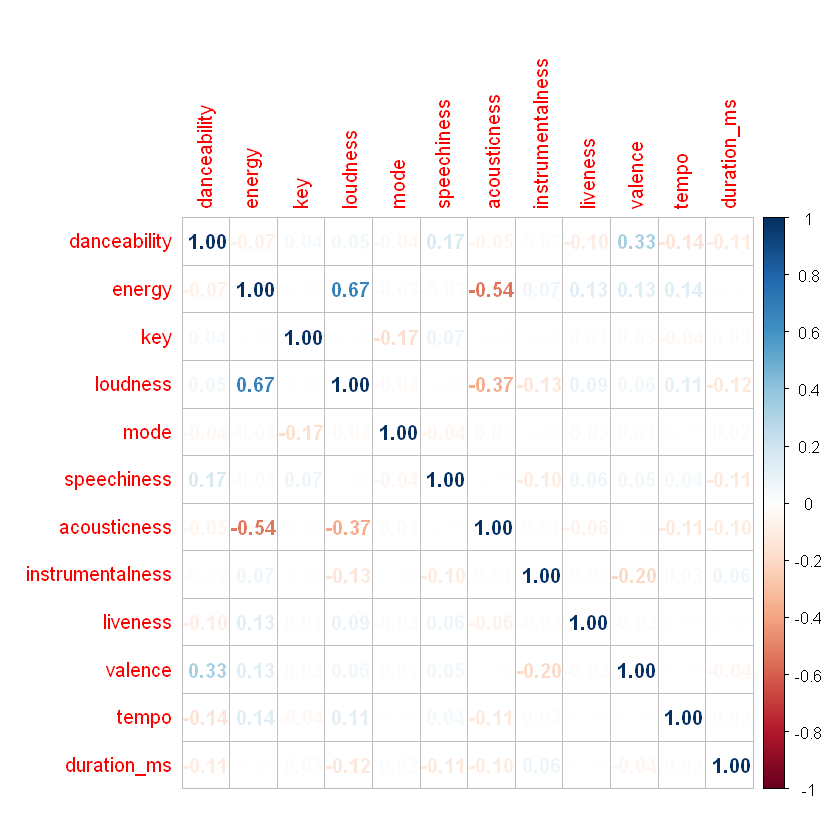

In [19]:
# Correlation
col_numeric <- c("danceability","energy","key","loudness", "mode", "speechiness","acousticness","instrumentalness",
                 "liveness","valence","tempo","duration_ms") 
M = cor(data_eda[, col_numeric])
corrplot(M, method = 'number')

***Conclusion:***

    - Most of the columns are not highly linear-correlated.
    - The correlation coefficiency between *Loudness* and *energy* is 0.67.

In [20]:
# pairs(~danceability+energy+key+loudness+mode+speechiness+
#       acousticness+instrumentalness+liveness+valence+tempo+duration_ms,
#       data=data_eda[sample(200), col_numeric],
#    main="Simple Scatterplot Matrix")

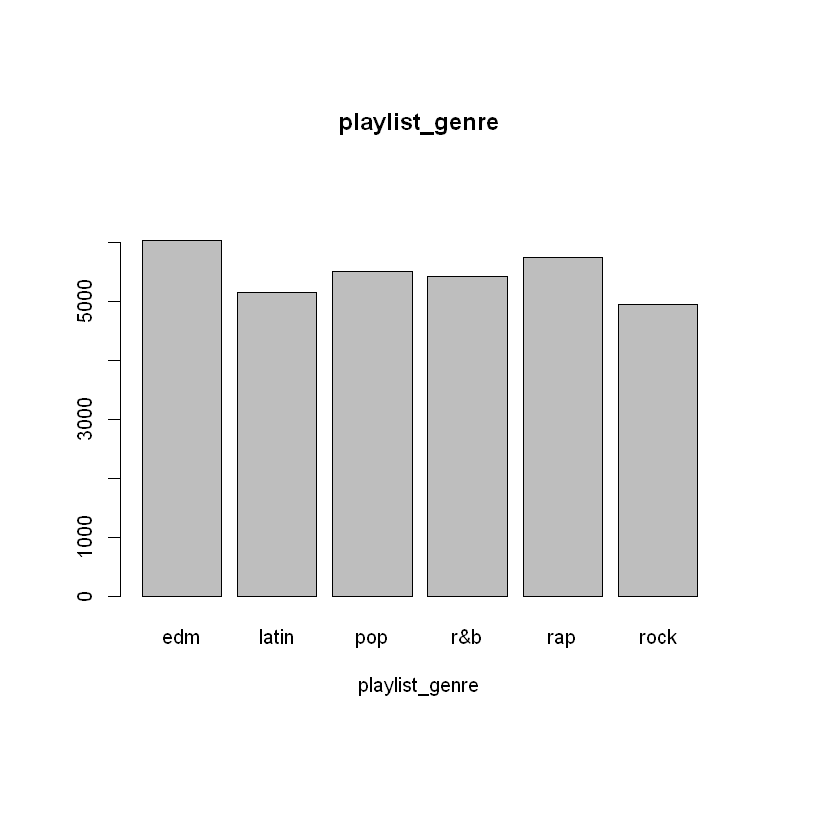

In [17]:
par(mar=c(10, 5, 10, 5))
barplot(table(raw_data[, "playlist_genre"]), main="playlist_genre", xlab="playlist_genre")

***Conclusion:***

    - Different categories of genre are almost evenly distributed.

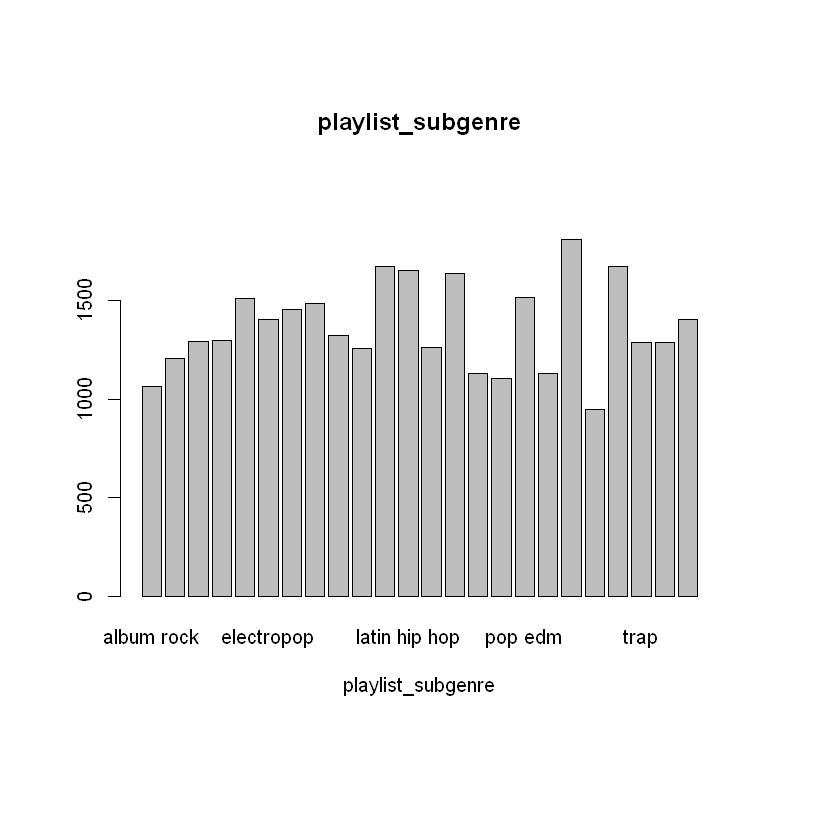

In [18]:
par(mar=c(10, 5, 10, 5))
barplot(table(raw_data[, "playlist_subgenre"]), main="playlist_subgenre", xlab="playlist_subgenre")

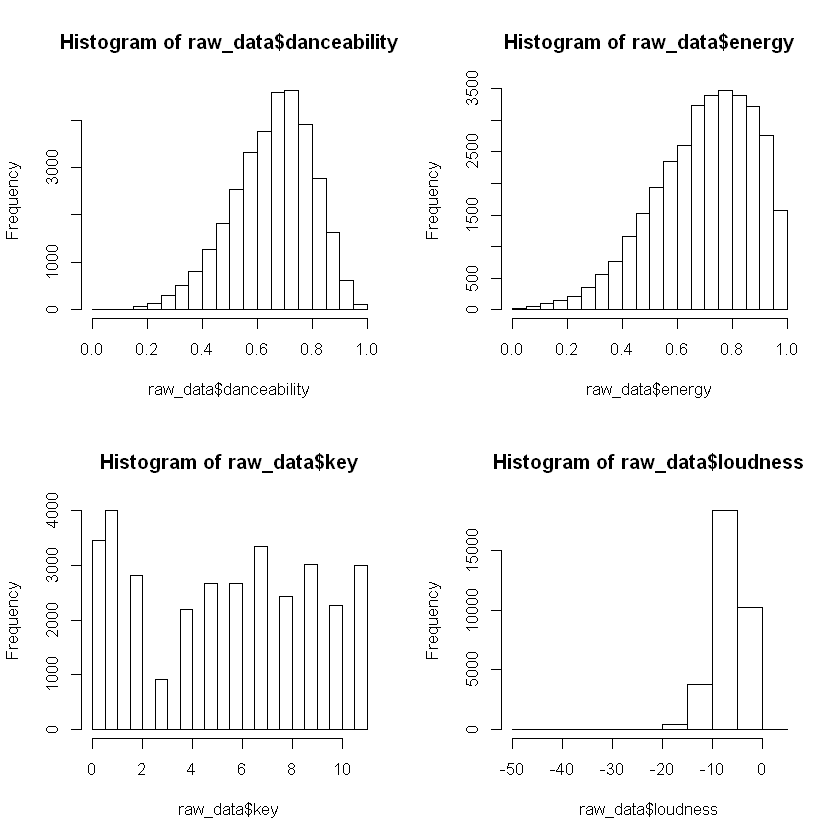

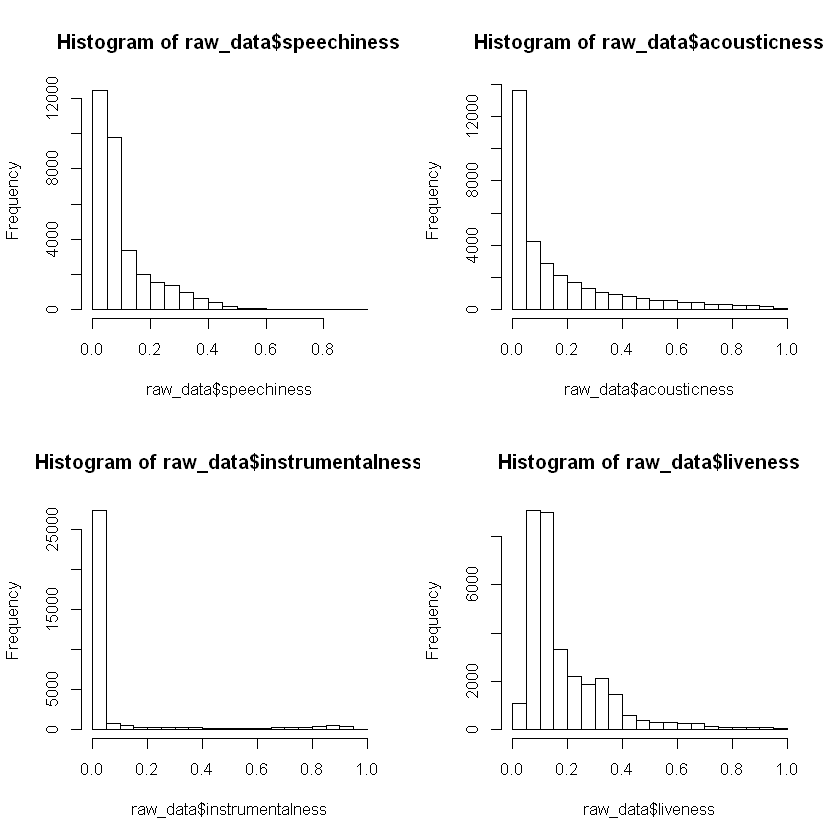

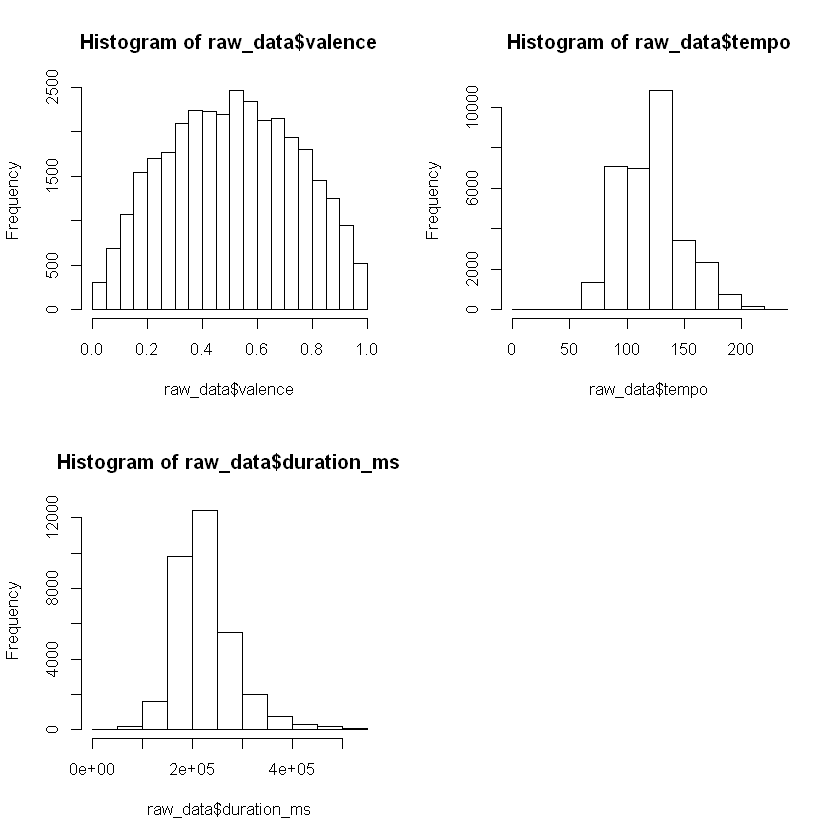

In [22]:
# Observe the data distribution, find skewness
par(mfrow = c(2, 2))
hist(raw_data$danceability)
hist(raw_data$energy)
hist(raw_data$key)
hist(raw_data$loudness)
hist(raw_data$speechiness)
hist(raw_data$acousticness)
hist(raw_data$instrumentalness)
hist(raw_data$liveness)
hist(raw_data$valence)
hist(raw_data$tempo)
hist(raw_data$duration_ms)

***Conclusion:***

    - Some differences exist in the distribution of subgenre.

### Data Pre-processing

In [23]:
# Remove rows with empty value
raw_data_rmna <- na.omit(raw_data)
print(paste("Remove rows with empty value:", nrow(raw_data) - nrow(raw_data_rmna)))
# Remove rows with duplicated track Id
raw_data_rmdup <- raw_data_rmna[!duplicated(raw_data_rmna[, c("track_id", "track_name")]),]
print(paste("Remove rows with duplicated track ID:", nrow(raw_data_rmna) - nrow(raw_data_rmdup)))

[1] "Remove rows with empty value: 5"
[1] "Remove rows with duplicated track ID: 4476"


In [24]:
# Normalize data
raw_data_norm <- raw_data_rmdup
process <- preProcess(raw_data_norm, method=c("range"))
raw_data_norm <- predict(process, raw_data_norm)

In [159]:
# Down sampling
# copy the dataset schema to a temporary dataframe
dataset <- raw_data_norm[0,]
for (genre in unique(raw_data_norm$playlist_genre)) {
    # for each sub data of differernt subgenre
    tmdf <- raw_data_norm[raw_data_norm$playlist_genre == genre,] 
    # sample part of the data
    tmdf <- tmdf[sample(nrow(tmdf), size=1000, replace=TRUE),]
    # combine it by rows to a new dataset
    dataset <- rbind(dataset, tmdf)
}
print(paste("Number of rows in the new dataframe", nrow(dataset)))

[1] "Number of rows in the new dataframe 6000"


In [160]:
summary(dataset)

   track_id          track_name        track_artist       track_popularity
 Length:6000        Length:6000        Length:6000        Min.   :0.0000  
 Class :character   Class :character   Class :character   1st Qu.:0.2200  
 Mode  :character   Mode  :character   Mode  :character   Median :0.4200  
                                                          Mean   :0.3953  
                                                          3rd Qu.:0.5800  
                                                          Max.   :1.0000  
 track_album_id     track_album_name   track_album_release_date
 Length:6000        Length:6000        Length:6000             
 Class :character   Class :character   Class :character        
 Mode  :character   Mode  :character   Mode  :character        
                                                               
                                                               
                                                               
 playlist_name      playlis

In [161]:
# Dummy
# head(model.matrix(~playlist_genre-1,data=raw_data))

In [162]:
# determine columns
summary(dataset)
id_cols = c('track_id','track_name')
category_cols = c('track_artist', 
                  'playlist_name', 'playlist_id', 
                  'track_album_id', 'track_album_name', 
                  'track_album_release_date')
numeric_cols = c('track_popularity', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms')
label_cols = c('playlist_genre', 'playlist_subgenre')

   track_id          track_name        track_artist       track_popularity
 Length:6000        Length:6000        Length:6000        Min.   :0.0000  
 Class :character   Class :character   Class :character   1st Qu.:0.2200  
 Mode  :character   Mode  :character   Mode  :character   Median :0.4200  
                                                          Mean   :0.3953  
                                                          3rd Qu.:0.5800  
                                                          Max.   :1.0000  
 track_album_id     track_album_name   track_album_release_date
 Length:6000        Length:6000        Length:6000             
 Class :character   Class :character   Class :character        
 Mode  :character   Mode  :character   Mode  :character        
                                                               
                                                               
                                                               
 playlist_name      playlis

In [163]:
# Split dataset
set.seed(123456)
dataset$playlist_genre <- as.factor(dataset$playlist_genre)
ind <- sample(2, nrow(dataset), replace=TRUE, prob=c(0.8, 0.2))
trainset <- dataset[ind==1,]
testset <- dataset[ind==2,]
cat("Training set has", nrow(trainset), "rows.\n")
cat("Testset set has", nrow(testset), "rows.")

Training set has 4787 rows.
Testset set has 1213 rows.

In [164]:
unique(trainset$playlist_genre)

[1] pop   rap   rock  latin r&b   edm  
Levels: edm latin pop r&b rap rock

In [190]:
# Implement function to calculate accuracy
get_accuracy <- function(pred, groundTrue) {
    res <- data.frame(pred, groundTrue)
    names(res) <- c("Prediction", "GroundTrue")
    res_stat <- res %>% group_by(Prediction, GroundTrue) %>% summarise(total_count=n())
    100*sum(res_stat[res_stat$Prediction==res_stat$GroundTrue,]$total_count)/sum(res_stat$total_count)
}

In [191]:
get_accuracy(testP, testY)

[1] 43.69332

#### KNN

In [192]:
trainX <- trainset[, numeric_cols]
trainY <- trainset$playlist_genre
testX <- testset[, numeric_cols]
testY <- testset[,names(testset)[names(testset)=="playlist_genre"]]

In [198]:
# Test different configuration: the number of neighours considerred
set.seed(123456)
list_k <- seq(5, 200, 5)
best_acc = 0
list_acc <- c()
best_k <- NULL
for (k in list_k) {
    pred <- knn(trainX, testX, cl=trainY, k=k)
    acc <- get_accuracy(pred, testY)
    list_acc <- append(list_acc, acc)
    if (best_acc < acc) {
        best_k = k
        best_acc = acc
    }
}

[1] 43.77576

[1] 60

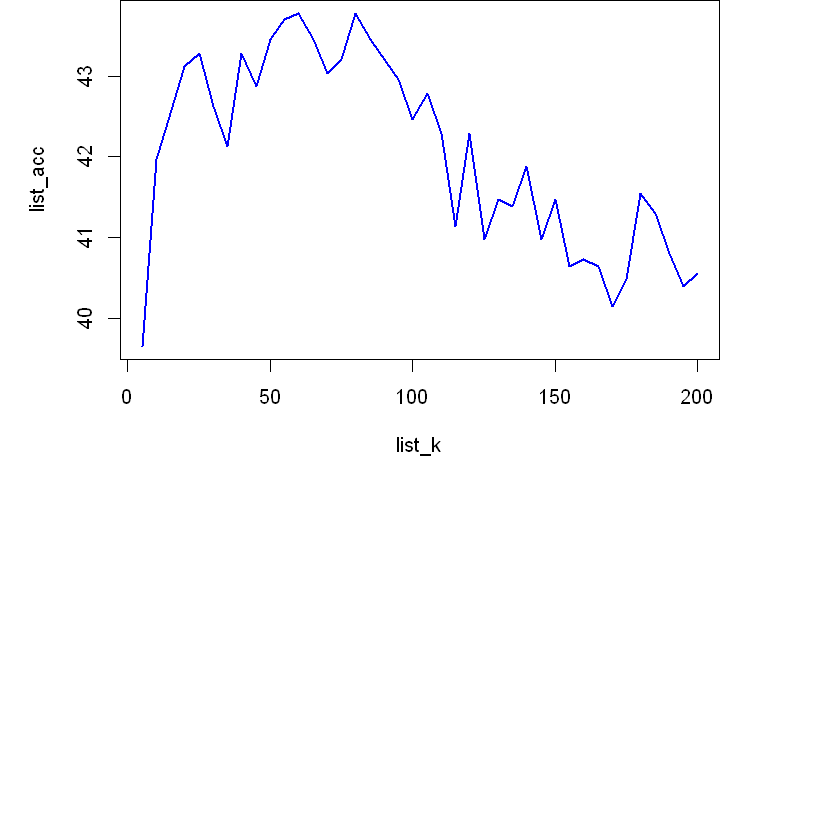

In [236]:
best_acc
best_k
par(mar=c(20, 5, 0, 5))
plot(list_k, list_acc, type="l", col="blue", lwd=2)

***Conclusion:***

    - The best KNN model under the context considers 30 neighbours.
    - The best accuracy is 43.776%.

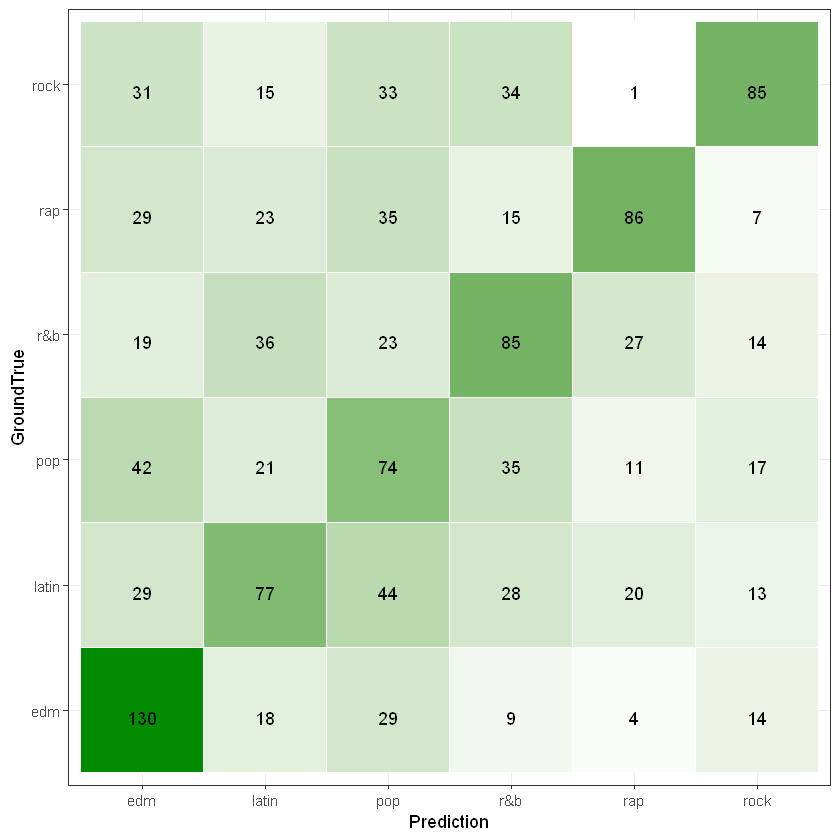

In [239]:
set.seed(123456)
pred <- knn(trainX, testX, cl=trainY, k=best_k)
# Aggregate predictions
res <- data.frame(pred, testY$playlist_genre)
names(res) <- c("Prediction", "GroundTrue")
res_stat <- res %>% group_by(Prediction, GroundTrue) %>% summarise(total_count=n())

par(mar=c(20, 5, 0, 5))
# Plot confusion matrix
ggplot(data=res_stat, mapping=aes(x=Prediction, y=GroundTrue)) + 
    geom_tile(aes(fill = total_count), colour = "white") +
    geom_text(aes(label=sprintf("%1.00f", total_count)), vjust = 1) +
    scale_fill_gradient(low="white", high="green4") +
    theme_bw() + theme(legend.position = "none")

Warning message in roc.default(as.numeric(pred), as.numeric(testY$playlist_genre)):
"'response' has more than two levels. Consider setting 'levels' explicitly or using 'multiclass.roc' instead"


Call:
roc.default(response = as.numeric(pred), predictor = as.numeric(testY$playlist_genre))

Data: as.numeric(testY$playlist_genre) in 280 controls (as.numeric(pred) 1) < 190 cases (as.numeric(pred) 2).
Area under the curve: 0.6206

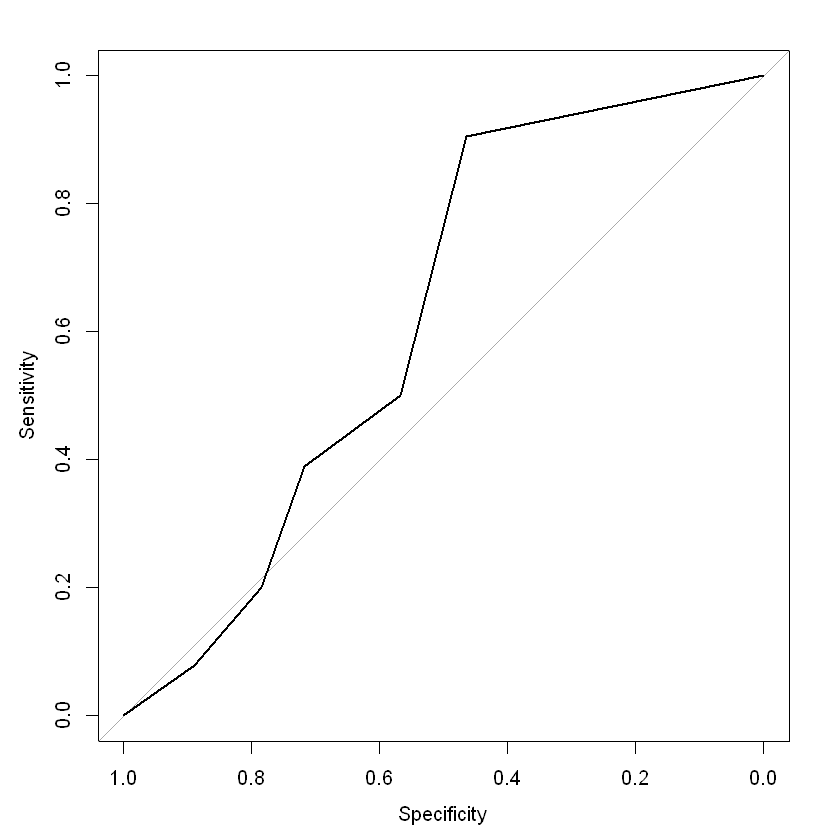

In [245]:
library(pROC)

# Evaluate ROC value
roc.playlist_genre <- roc(as.numeric(pred), as.numeric(testY$playlist_genre))

roc.playlist_genre
plot(roc.playlist_genre)

In [242]:
res_stat[res_stat$Prediction == res_stat$GroundTrue, ]
acc <- sum(res_stat[res_stat$Prediction == res_stat$GroundTrue, ]$total_count)/sum(res_stat$total_count)
acc

Prediction,GroundTrue,total_count
edm,edm,130
latin,latin,77
pop,pop,74
r&b,r&b,85
rap,rap,86
rock,rock,85


[1] 0.442704

#### LDA

[1] 45.42457


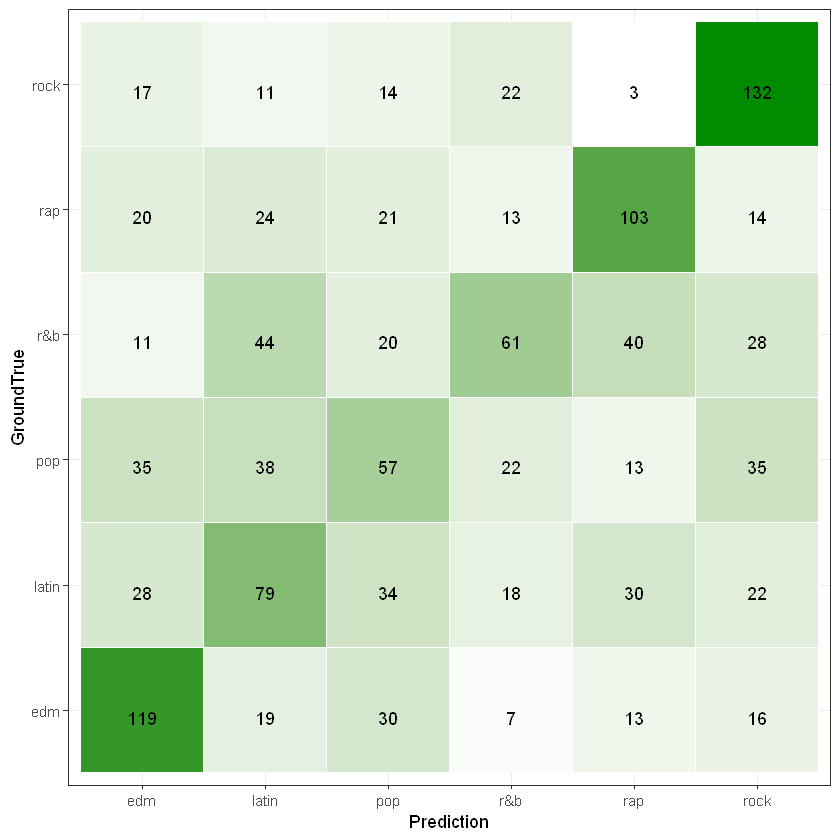

In [264]:
# https://www.r-bloggers.com/2021/05/linear-discriminant-analysis-in-r/
library(MASS)

# Fit the LDA model, return the classifier
linear <- lda(playlist_genre~., trainset[,c(numeric_cols, "playlist_genre")])


# Make prediction
pred <- predict(linear, testset[,c(numeric_cols, "playlist_genre")])
print(get_accuracy(pred$class, testY))
# ldahist(data=p$x[,1], g=trainset[,c(numeric_cols, "playlist_genre")]$playlist_genre)

# Aggregate predictions
res <- data.frame(pred$class, testY$playlist_genre)
names(res) <- c("Prediction", "GroundTrue")
res_stat <- res %>% group_by(Prediction, GroundTrue) %>% summarise(total_count=n())

# Plot confusion matrix
ggplot(data=res_stat, mapping=aes(x=Prediction, y=GroundTrue)) + 
    geom_tile(aes(fill = total_count), colour = "white") +
    geom_text(aes(label=sprintf("%1.00f", total_count)), vjust = 1) +
    scale_fill_gradient(low="white", high="green4") +
    theme_bw() + theme(legend.position = "none")

Warning message in roc.default(as.numeric(pred$class), as.numeric(testY$playlist_genre)):
"'response' has more than two levels. Consider setting 'levels' explicitly or using 'multiclass.roc' instead"


Call:
roc.default(response = as.numeric(pred$class), predictor = as.numeric(testY$playlist_genre))

Data: as.numeric(testY$playlist_genre) in 230 controls (as.numeric(pred$class) 1) < 215 cases (as.numeric(pred$class) 2).
Area under the curve: 0.6764

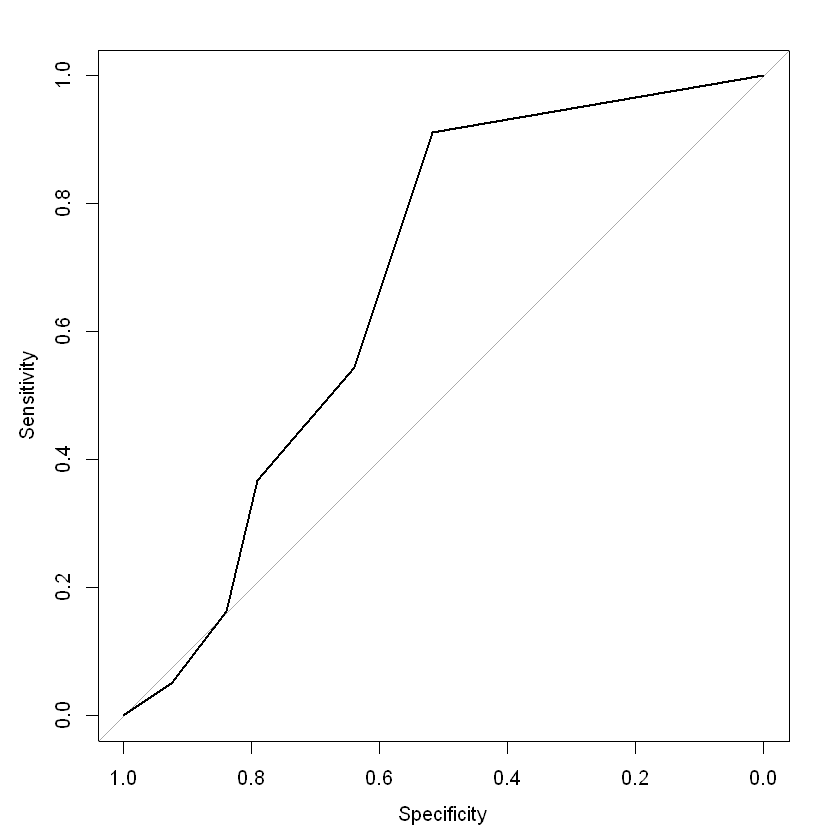

In [265]:
# Evaluate ROC value
roc.playlist_genre <- roc(as.numeric(pred$class), as.numeric(testY$playlist_genre))
roc.playlist_genre
plot(roc.playlist_genre)

In [266]:
res_stat[res_stat$Prediction == res_stat$GroundTrue, ]
# acc <- sum(res_stat[res_stat$Prediction == res_stat$GroundTrue, ]$total_count)/sum(res_stat$total_count)

Prediction,GroundTrue,total_count
edm,edm,119
latin,latin,79
pop,pop,57
r&b,r&b,61
rap,rap,103
rock,rock,132


#### Random Forest

In [255]:
# library(randomForest)

set.seed(123456)
rf <- randomForest(playlist_genre~., data=trainset[,c(numeric_cols, "playlist_genre")], importance=TRUE, proximity=TRUE)
rf


Call:
 randomForest(formula = playlist_genre ~ ., data = trainset[,      c(numeric_cols, "playlist_genre")], importance = TRUE, proximity = TRUE) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 3

        OOB estimate of  error rate: 38.75%
Confusion matrix:
      edm latin pop r&b rap rock class.error
edm   568    46  67  32  39   44   0.2864322
latin  65   394  88 108 100   34   0.5006337
pop    92   100 341  85  56  126   0.5737500
r&b    23    76  66 437 128   66   0.4510050
rap    43    62  31  81 565   23   0.2981366
rock   33    27  44  58  12  627   0.2172285

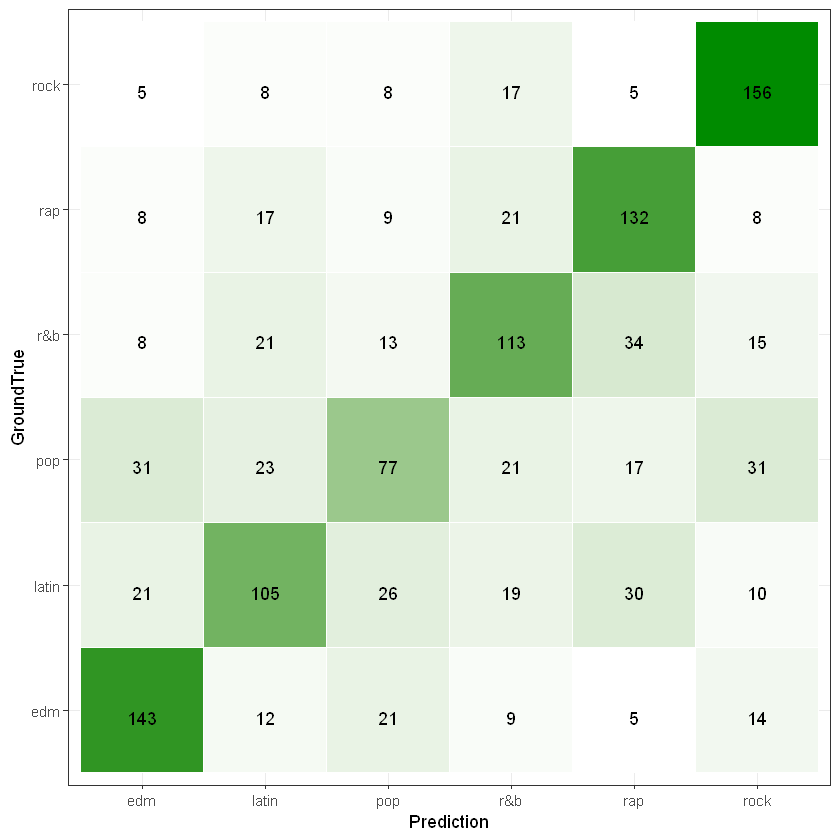

In [256]:
pred <- predict(rf, testset[,c(numeric_cols, "playlist_genre")])
pred <- data.frame(pred)
names(pred) = c("class")
# Aggregate predictions
res <- data.frame(pred$class, testY$playlist_genre)
names(res) <- c("Prediction", "GroundTrue")
res_stat <- res %>% group_by(Prediction, GroundTrue) %>% summarise(total_count=n())

# Plot confusion matrix
ggplot(data=res_stat, mapping=aes(x=Prediction, y=GroundTrue)) + 
    geom_tile(aes(fill = total_count), colour = "white") +
    geom_text(aes(label=sprintf("%1.00f", total_count)), vjust = 1) +
    scale_fill_gradient(low="white", high="green4") +
    theme_bw() + theme(legend.position = "none")

Accuracy:  59.85161 %


Warning message in roc.default(as.numeric(pred$class), as.numeric(testY$playlist_genre)):
"'response' has more than two levels. Consider setting 'levels' explicitly or using 'multiclass.roc' instead"


Call:
roc.default(response = as.numeric(pred$class), predictor = as.numeric(testY$playlist_genre))

Data: as.numeric(testY$playlist_genre) in 216 controls (as.numeric(pred$class) 1) < 186 cases (as.numeric(pred$class) 2).
Area under the curve: 0.7594

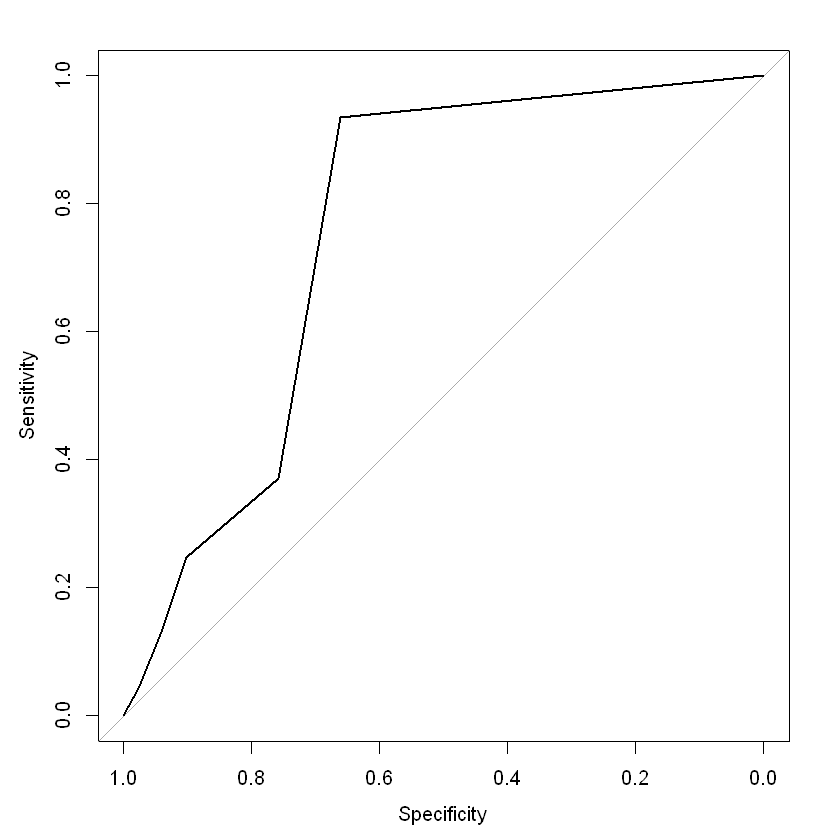

In [260]:
cat("Accuracy: ", get_accuracy(pred, testY), '%\n')
# Evaluate ROC value
roc.playlist_genre <- roc(as.numeric(pred$class), as.numeric(testY$playlist_genre))
# par(mfrow = c(2, 2))
roc.playlist_genre
plot(roc.playlist_genre)

In [262]:
res_stat[res_stat$Prediction == res_stat$GroundTrue, ]

Prediction,GroundTrue,total_count
edm,edm,143
latin,latin,105
pop,pop,77
r&b,r&b,113
rap,rap,132
rock,rock,156


In [ ]:
# Data preprocessing 数据预处理（数据清洗）

# 1. 确定列数据类型

# 2. 处理缺失值

# 3. 处理噪音数据 outlier

# 4. 处理重复记录
# raw_data[!duplicated(raw_data),]

In [ ]:
# Data Transformation 数据转换

# 1. 类别数据离散化 data dumming （比如字符串类别数据按类别转换成 0-1 特征向量

# 2. 特征选择（ID等唯一性的特征可以省略掉）

# 3. 数据规范化、归一化 （改变数据的分布，便于加速求解收敛）


In [289]:
# print(table(raw_data$playlist_genre))
# print(length(category_cols))
# cols = 2
# rows = length(category_cols)/2

# par(mfrow = c(5, 1))
# for (i in category_cols[1:length(category_cols)]) {
#     barplot(
#         table(raw_data[, i]), 
#         main=i, 
#         xlab=i)
# }